# Introduction
The Discounted Cash Flow (DCF) Model is one of the most commonly used methods to value equity.
It is based on the principle that the value of any asset is equal to the present value of the cash flows that it generates in the future. 
In this project, we will be building a DCF Model to predict the equity price of a company using Python,
which can help people interested in finance to have an automatic and easy to use technical toolkit in 
understanding the predicted future stock price of a company.

# 1. Load Packages and Obtain data

In [1]:
# Import the necessary packages. 
# Note that you may need to install some packages, e.g., yfinance.
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import requests
import urllib.request as ur
from urllib.request import urlopen
import yfinance as yf
import numpy as np
from bs4 import BeautifulSoup
import yahooquery as yq
from sklearn.linear_model import LinearRegression
from datetime import datetime
import plotly.express as px
import PySimpleGUI as sg

First, we create a series of empty lists to store the data,
which will be used to create a dataframe later.
These are important categories in a DCF model to calculate unlevered free cash flow.

In [2]:
Revenue_list = []
# Store the revenue data
Operating_Income_list = []
# Store the operating income data
Income_Tax_List = [] 
# Store the income tax data
Net_Profit_After_Tax_list = []
# Store the net profit after tax data
# calculated by operating income-tax
Depreciation_Amorization_list = []
# Store the depreciation and amortization data
Stock_Based_Compensation_list = []
# Store the stock based compensation data
Change_in_Operating_Assets_list = []
# Store the change in operating assets data
Operating_Cash_Flow_list = [] 
# Store the operating cash flow data
# calculated by net profit after tax+depreciation+stock based compensation+change in operating assets
Capital_Expense_list = []
# Store the capital expense data
Free_Cash_Flow_list = [] 
# Store the free cash flow data
#calculated by operating cash flow-capital expense
time_list = []
# store the time for each data point

Next, We will be using the financialmodelingprep.com API to get the data.

financialmodelingprep.com is a free API that provides financial data for companies.

The API key is required to access the data.

You can get your own API key by registering at https://financialmodelingprep.com/developer

In [3]:
# We will be using ticker to indicate what company stock you are looking for.
# e.g. ticker = 'AAPL' for Apple Inc.
# ticker is basically a abbreviation for a company stock.
ticker=input("Please enter your ticker")

# Some parameters that will be useful for data acquisition. 

# This is the maximum number of years we can retrieve. 
limit=20
# This is the number of years of data we want to look at.
pastyear=5
# current year
nowyear=2023
# set the time period to annual
# Period is ttm(trailing twelve month) | annual | quarter.
period='annual'
# we are only using the free version, so we can only get annual/ttm data. 
# If you want to see quarter, you need to purchase the premium version.


# This is the API key for financialmodelingprep.com
key = 'db6297f43527b1304c6628850f3da056'

def get_income_statement(ticker, limit, key, period):
    """Function to Get the Income Statement."""
    # Set the Income-statement URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/income-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}?limit={}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       limit,
                                                       key))
        # Convert the data into a dataframe
        incomeStatement = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        incomeStatement.columns = incomeStatement.iloc[0]
        # Drop the first row
        return incomeStatement[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Income statement sheet ERROR: ', str(e))

def get_balance_sheet(ticker, limit, key, period):
    """Get the Balance sheet."""
    # Set the Balance Sheet URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/balance-sheet-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        balanceSheet = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        balanceSheet.columns = balanceSheet.iloc[0]
        # Drop the first row
        return balanceSheet[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Balance sheet statement ERROR: ', str(e))



def get_cash_flow_statement(ticker, limit, key, period):
    """Get the Cash flow statements."""
    # Set the cash flow statements URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/cash-flow-statement/'
    try:
        # Get the data from the API
        r = requests.get(
            '{}{}?period={}&?limit={}&apikey={}'.format(URL,
                                                        ticker,
                                                        period,
                                                        limit,
                                                        key))
        # Convert the data into a dataframe
        cashFlow = pd.DataFrame.from_dict(r.json()).transpose()
        # Set the column names to the first row
        cashFlow.columns = cashFlow.iloc[0]
        # Drop the first row
        return cashFlow[1:]
    # If there is an error, print the error
    except requests.exceptions.HTTPError as e:
        print('Requesting Cash flow statement ERROR: ', str(e))


def get_financial_ratios(ticker, limit, key, period):
    """Get the Financial ratios."""
    """Period is ttm | annual | quarter."""
    # Set the URL for the API
    URL = 'https://financialmodelingprep.com/api/v3/'
    # If the period is ttm, then we need to use different columns than quarter/annual
    if period == "ttm":
        # Get the data from the API
        try:
            r = requests.get(
                '{}/ratios-ttm/{}?{}&apikey={}'.format(URL,
                                                       ticker,
                                                       period,
                                                       key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # column names are ticker name + TTM Ratios
            fr.columns = [ticker + " TTM Ratios"]
            return fr
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(1): ', str(e))
    # If the period is annual/quarter, then we need to use different columns than ttm
    elif period == "annual" or period == "quarter":
        try:
            # Get the data from the API
            r = requests.get(
                '{}ratios/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                   ticker,
                                                                   period,
                                                                   limit,
                                                                   key))
            # Convert the data into a dataframe
            fr = pd.DataFrame.from_dict(r.json()).transpose()
            # Set the column names to the second row
            fr.columns = fr.iloc[1]
            # Drop the first two rows
            return fr[2:]
        # If there is an error, print the error
        except requests.exceptions.HTTPError as e:
            print('Requesting Financial ratios ERROR(2): ', str(e))
    # If the period is not ttm/annual/quarter, then we need to print an error
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None

def get_key_metrics(ticker, limit, key, period):
    """
    Get the key metrics of a company such as Market capitalization, PE ratio, Price
    to sale ration, etc.
    ticker: the ticker of the company
    limit: the number of years of key metrics
    key: the API key
    period: the period of the key metrics: ttm | annual | quarter 
    (quarterly is only avaliable for subscribers)

    Return: a dataframe of the key metrics
    """

    URL = 'https://financialmodelingprep.com/api/v3/'
    if period == "ttm":
        try:
            r = requests.get(
                '{}key-metrics-ttm/{}?apikey={}'.format(URL, ticker, key))
            #get the data from the API
            km = pd.DataFrame.from_dict(r.json()).transpose() 
            #convert the data into a dataframe and transpose the dataframe
            km.columns = [ticker + " TTM Ratios"] #rename the column
            return km
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrics ERROR(1): ', str(e))
    elif period == "annual" or period == "quarter":
        try:
            r = requests.get(
                '{}key-metrics/{}?period={}&?limit={}&apikey={}'.format(URL,
                                                                        ticker,
                                                                        period,
                                                                        limit,
                                                                        key))
            km = pd.DataFrame.from_dict(r.json()).transpose()
            km.columns = km.iloc[1] 
            return km[2:]
        except requests.exceptions.HTTPError as e:
            print('Requesting Key Metrcs ERROR(2): ', str(e))
    else:
        print('ERROR: Define the period you want: ttm | annual | quarter')
        return None
    
def get_enterprise_value(ticker, rate, key, period):
    """
    The function creates a dataframe of the enterprise value of a company based on the company's finance statement. 
    It is calculated from market value.
    ticker: the ticker of the company
    rate: the number of years of enterprise value
    key: the API key
    period: the period of the enterprise value: ttm | annual | quarter
    Return: a dataframe of the enterprise value
    """
    URL = 'https://financialmodelingprep.com/api/v3/enterprise-values/'
    try:
        r = requests.get('{}{}?period={}&limit={}&apikey={}'.format(URL,
                                                                    ticker,
                                                                    period,
                                                                    rate,
                                                                    key))
        return pd.DataFrame.from_dict(r.json())
    except requests.exceptions.HTTPError as e:
        print('Requesting Enterprise Value ERROR: ', str(e))

It might be useful to also get the date of today and five years ago today

In [4]:
date = datetime.today().strftime('%Y-%m-%d')
date

last_year = datetime.today().year - 5
month = datetime.today().month
day = datetime.today().day

try:
    # try returning same date last year
    last_year_date = datetime.strptime(f"{last_year}-{month}-{day}",'%Y-%m-%d').date()
except ValueError: 
    # incase of error due to leap year, return date - 1 in last year
    last_year_date = datetime.strptime(f"{last_year}-{month}-{day-1}",'%Y-%m-%d').date()

print(last_year_date)

2018-05-23


Then, we visualize the dataframe that store the results by running the above functions on the designated Stock

In [5]:
df_income_statement=get_income_statement(ticker,limit,key,period)
# Create a dataframe using the get_income_statement function
df_balance_sheet=get_balance_sheet(ticker,limit,key,period)
# Create a dataframe using the get_balance_sheet function
df_cash_flow_statement=get_cash_flow_statement(ticker,limit,key,period)
# Create a dataframe using the get_cash_flow_statement function
key_metrics = get_key_metrics(ticker, limit, key, period)
# Create a dataframe using the get_key_metrics function
df_get_enterprise_value = get_enterprise_value(ticker, rate=10, key=key, period=period)
# Create a dataframe using the get_enterprise_value function

In [6]:
#Displaying Income Statement. 
df_income_statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
revenue,394328000000,365817000000,274515000000,260174000000,265595000000
costOfRevenue,223546000000,212981000000,169559000000,161782000000,163756000000
grossProfit,170782000000,152836000000,104956000000,98392000000,101839000000


In [7]:
df_balance_sheet
# Displaying Balance Sheet

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
cashAndCashEquivalents,23646000000,34940000000,38016000000,48844000000,25913000000
shortTermInvestments,24658000000,27699000000,52927000000,51713000000,40388000000
cashAndShortTermInvestments,48304000000,62639000000,90943000000,100557000000,66301000000


In [8]:
df_cash_flow_statement
# Displaying Cash Flow Statement

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
symbol,AAPL,AAPL,AAPL,AAPL,AAPL
reportedCurrency,USD,USD,USD,USD,USD
cik,0000320193,0000320193,0000320193,0000320193,0000320193
fillingDate,2022-10-28,2021-10-29,2020-10-30,2019-10-31,2018-11-05
acceptedDate,2022-10-27 18:01:14,2021-10-28 18:04:28,2020-10-29 18:06:25,2019-10-30 18:12:36,2018-11-05 08:01:40
calendarYear,2022,2021,2020,2019,2018
period,FY,FY,FY,FY,FY
netIncome,99803000000,94680000000,57411000000,55256000000,59531000000
depreciationAndAmortization,11104000000,11284000000,11056000000,12547000000,10903000000
deferredIncomeTax,895000000,-4774000000,-215000000,-340000000,-32590000000


In [9]:
key_metrics
# Displaying Key Metrics.

date,2022-09-24,2021-09-25,2020-09-26,2019-09-28,2018-09-29
period,FY,FY,FY,FY,FY
revenuePerShare,24.317273,21.903541,15.820258,14.085283,13.399334
netIncomePerShare,6.154614,5.669029,3.308587,2.991446,3.003354
operatingCashFlowPerShare,7.532763,6.229346,4.64923,3.756685,3.906565
freeCashFlowPerShare,6.872426,5.565624,4.228014,3.188508,3.23492
cashPerShare,2.978793,3.750553,5.241031,5.443948,3.344902
bookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
tangibleBookValuePerShare,3.124822,3.777557,3.765477,4.898834,5.405593
shareholdersEquityPerShare,3.124822,3.777557,3.765477,4.898834,5.405593
interestDebtPerShare,7.585118,7.626006,6.64524,6.043039,5.939155


In [10]:
df_get_enterprise_value
# Displaying Enterprise Value dataframe.

,symbol,date,stockPrice,numberOfShares,marketCapitalization,minusCashAndCashEquivalents,addTotalDebt,enterpriseValue
0,AAPL,2022-09-24,150.4300,16215963000,2439367314090,23646000000,120069000000,2535790314090
1,AAPL,2022-09-24,150.4300,16215963000,2439367314090,23646000000,120069000000,2535790314090
2,AAPL,2021-09-25,146.9200,16701272000,2453750882240,34940000000,124719000000,2543529882240
3,AAPL,2020-09-26,112.2800,17352119000,1948295921320,38016000000,112436000000,2022715921320
4,AAPL,2019-09-28,54.7050,18471336000,1010474435880,48844000000,108047000000,1069677435880
5,AAPL,2018-09-29,56.4350,19821508000,1118626803980,25913000000,114483000000,1207196803980
6,AAPL,2017-09-30,38.5300,20868968000,804081337040,20289000000,115680000000,899472337040
7,AAPL,2016-09-24,28.1775,21883280000,616616122200,20484000000,87032000000,683164122200
8,AAPL,2015-09-26,28.6775,23013684000,659974922910,21120000000,64462000000,703316922910
9,AAPL,2014-09-27,25.1875,24342288000,613121379000,13844000000,35295000000,634572379000


# 2. Fetch and clean the required data 

In this step, we create some lists to store the value of the past few years for specific variables like the company's revenue, operating income, capital expense, and so on. 

In [11]:
revenue_list=list(df_income_statement.loc['revenue'][:pastyear].copy().values).copy()
#Create a list of company's revenue
Operating_Income_List=list(df_income_statement.loc['operatingIncome'][:pastyear].copy().values).copy()
##Create a list of company's operating income
Income_Tax_List = list(df_income_statement.loc['incomeTaxExpense'][:pastyear].copy().values).copy()
##Create a list of company's income tax
Depreciation_Amorization_list=list(df_cash_flow_statement.loc['depreciationAndAmortization'][:pastyear].copy().values).copy()
##Create a list of company's depreciation and amortization
Stock_Based_Compensation_list=list(df_cash_flow_statement.loc['stockBasedCompensation'][:pastyear].copy().values).copy()
##Create a list of company's stock based compensation
Operating_Cash_Flow_list = list(df_cash_flow_statement.loc['operatingCashFlow'][:pastyear].copy().values).copy()
##Create a list of company's operating cash flow
Captial_Expense_List=list(df_cash_flow_statement.loc['capitalExpenditure'][:pastyear].copy().values).copy()
##Create a list of company's capital expenditure
#Net_Income_list=list(df_income_statement.loc['netIncome'][:pastyear].copy().values).copy()
#Create a list of company's net income

In [12]:
revenue_list.reverse() 
#reverse the list of revenue so that the first element is the oldest revenue in time order
Operating_Income_List.reverse()
#reverse the list of operating income so that the first element is the oldest operating income in time order
Income_Tax_List.reverse()
Depreciation_Amorization_list.reverse()
Stock_Based_Compensation_list.reverse()
Operating_Cash_Flow_list.reverse()
Captial_Expense_List.reverse()
# Net_Income_list.reverse()
time_list=[nowyear-i for i in range(pastyear-1,-1,-1)]
Present_Year=time_list[0] #Set the present year that is used to discount the future cashflow


In [13]:
growth_rate_list=[]
for i in range(0,len(revenue_list)-1):
    growth_rate_list.append((revenue_list[i+1]-revenue_list[i])/revenue_list[i])

#  Net_Income_Margin_list=[]
# for i in range(0,len(Net_Income_list)):
#     Net_Income_Margin_list.append(Net_Income_list[i]/revenue_list[i]) 
#Use formula to calculate the net income margin of the company and store it into a list

Operating_Income_Margin_list=[]
for i in range(0,len(Operating_Income_List)):
    Operating_Income_Margin_list.append(Operating_Income_List[i]/revenue_list[i])

Net_Profit_After_Tax_list = []
for i in range(0, len(Operating_Income_List)):
    Net_Profit_After_Tax_list.append(Operating_Income_List[i]-Income_Tax_List[i])

DA_margin_list = []
for i in range(0, len(Depreciation_Amorization_list)):
    DA_margin_list.append(Depreciation_Amorization_list[i]/revenue_list[i])

Stock_Based_Compensation_margin_list = []
for i in range(0, len(Stock_Based_Compensation_list)):
    Stock_Based_Compensation_margin_list.append(Stock_Based_Compensation_list[i]/revenue_list[i])

Change_in_Operating_Assets_list = []
for i in range(0, len(Net_Profit_After_Tax_list)):
    Change_in_Operating_Assets_list.append(Operating_Cash_Flow_list[i]-(Net_Profit_After_Tax_list[i]+Depreciation_Amorization_list[i]+Stock_Based_Compensation_list[i]))

Change_in_Operating_Assets_margin_list = []
for i in range(0, len(Change_in_Operating_Assets_list)):
    Change_in_Operating_Assets_margin_list.append(Change_in_Operating_Assets_list[i]/revenue_list[i])

Capital_Expense_margin_list = []
for i in range(0, len(Captial_Expense_List)):
    Capital_Expense_margin_list.append(Captial_Expense_List[i]/revenue_list[i])

Free_Cash_Flow_list = []
for i in range(0, len(Operating_Cash_Flow_list)):
    Free_Cash_Flow_list.append(Operating_Cash_Flow_list[i]-abs(Captial_Expense_List[i]))

# FCF_Net_Income_Rate_List=[]
# for i in range(0,len(Free_Cash_Flow_list)):
#    FCF_Net_Income_Rate_List.append(Free_Cash_Flow_list[i]/Net_Income_list[i])
#Calculate the free cash flow to net income rate of the company and store it into a list

FCF_Operating_Income_Rate_list = []
for i in range(0, len(Free_Cash_Flow_list)):
    FCF_Operating_Income_Rate_list.append(Free_Cash_Flow_list[i]/Operating_Income_List[i])

# 3. Data Visualization

In this step, we create data frames to use time series plots to visualize the development trend over time for our interested variables.

In [14]:
df_revenue=pd.DataFrame({'time':time_list,'revenue':revenue_list})
df_Operating_Income_Margin=pd.DataFrame({'time':time_list,'Operating income margin':Operating_Income_Margin_list})
df_FCF_OI_Rate=pd.DataFrame({'time':time_list,'Rate of FCF over Operating Income':FCF_Operating_Income_Rate_list})
time_list2=time_list.copy()
time_list2.remove(time_list2[-1])
df_growth_rate=pd.DataFrame({'time':time_list2,'Revenue Growth Rate':growth_rate_list})

# df_revenue.plot(x='time',y='revenue',xticks=time_list,
#                 title=f'Revenue of {ticker} (in 100 billions)')
# df_Operating_Income_Margin.plot(x='time',y='Operating income margin'
#                                 ,xticks = time_list, title = f'Operating Income Margin of {ticker}')
# df_FCF_OI_Rate.plot(x='time',y='Rate of FCF over Operating Income',
#                     xticks = time_list, title = f'Rate of FCF over Operating Income of {ticker}')
# df_growth_rate.plot(x='time',y='Revenue Growth Rate',
#                     xticks = time_list, title = f'Revenue Growth Rate of {ticker}')


In [15]:
fig = px.line(df_revenue,x='time',y='revenue',
title=f'Revenue of {ticker} (in 100 billions)', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

In [16]:
fig = px.line(df_Operating_Income_Margin,x = 'time',y = 'Operating income margin',
title = f'Rate of FCF over Operating Income of {ticker}', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

In [17]:
fig = px.line(df_growth_rate,x = 'time',y = 'Revenue Growth Rate',
title = f'Revenue Growth Rate of {ticker}', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

In [18]:
fig = px.line(df_FCF_OI_Rate,x = 'time',y = 'Rate of FCF over Operating Income',
title = f'Rate of FCF over Operating Income of {ticker}', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

# 4. Modeling

In [19]:
choose_growth_rate=sum(growth_rate_list)/len(growth_rate_list)
choose_Operating_Income_Margin_rate=sum(Operating_Income_Margin_list)/len(Operating_Income_Margin_list)
choose_free_cash_flow_OI_rate=sum(FCF_Operating_Income_Rate_list)/len(FCF_Operating_Income_Rate_list)
prediction_time=4

list3=time_list.copy()
revenue_list1=revenue_list.copy()
Operating_Income_list1=Operating_Income_list.copy()
Free_Cash_Flow_list1=Free_Cash_Flow_list.copy()

Back_Up_Time_List=list(range(list3[-1]+1,list3[-1]+prediction_time+1)) #Create a list of future time
list3=list3+list(range(list3[-1]+1,list3[-1]+prediction_time+1)) #Create a list of time from past n years to future years
Back_Up_Free_Cash_Flow=[]

In [20]:
for i in range(0,prediction_time):
    a=revenue_list1[-1]*(1+choose_growth_rate)
    #a is the predicted revenue for the next year
    revenue_list1.append(a)
    b=revenue_list1[-1]*(choose_Operating_Income_Margin_rate)
    #b is the predicted operating income for the next year
    Operating_Income_list1.append(b)
    c=Operating_Income_list1[-1]*(choose_free_cash_flow_OI_rate)
    #c is the predicted free cash flow for the next year
    Free_Cash_Flow_list1.append(c)
    Back_Up_Free_Cash_Flow.append(c)


In [21]:
df_future_free_cash_flow=pd.DataFrame({'time':list3,'free cash flow prediction':Free_Cash_Flow_list1})
#df_future_free_cash_flow.plot(x='time',y='free cash flow prediction',xticks = list3, title = f'Free cash flow prediction of {ticker} in 100 billions')

In [22]:
fig = px.line(df_future_free_cash_flow,x = 'time',y = 'free cash flow prediction',
title = f'Free cash flow prediction of {ticker} in 100 billions', markers=True)
fig.update_xaxes(dtick="M1")
fig.show()

In [23]:
total_debt=list(df_get_enterprise_value['addTotalDebt'][:1].values)[0]
# Total debt is the aggregate of all the company's debts.
Market_Cap=list(df_get_enterprise_value['marketCapitalization'][:1].values)[0]
# total value of a publicly traded company's outstanding common shares owned by stockholders
# equal to the total value of company's equity.
OutstandingSharing=list(df_get_enterprise_value['numberOfShares'][:1].values)[0]
# The number of shares outstanding is listed on a company's balance sheet as "Capital Stock" and is reported on the
# company's quarterly filings with the US Securities and Exchange Commission.
Interest_Expense=list(df_income_statement.loc['interestExpense'][:1].values)[0]
# Interest expense is the cost of borrowing money.
Long_Term_Debt=list(df_balance_sheet.loc['longTermDebt'][:1].values)[0]
# Long-term debt is debt that matures in more than one year and is often treated differently from short-term debt.
Short_Term_Debt=list(df_balance_sheet.loc['shortTermDebt'][:1].values)[0]
# Short-term debt, also called current liabilities, is a firm's financial obligations that are expected to be paid off
Income_Tax=list(df_income_statement.loc['incomeTaxExpense'].values)[0]
# Income tax expense is the amount of expense that a business recognizes in an accounting period for the taxes owed
Income_Before_Tax=list(df_income_statement.loc['incomeBeforeTax'].values)[0]
# Income before tax is a measure of a company's profitability that looks at pretax earnings, or earnings before taxes.




Risk_Free_Rate=0.0346
# 10-year Treasury rate
## Define the URL of the webpage containing the risk-free rate
# url = "https://ycharts.com/indicators/10_year_treasury_rate"  # Replace with the actual URL

# # Send a GET request to fetch the webpage content
# response = requests.get(url)

# # Parse the HTML content
# soup = BeautifulSoup(response.content, "html.parser")

# # Use appropriate CSS selectors or XPath expressions to extract the risk-free rate
# risk_free_rate = soup.select_one("#rate-element").text  # Replace with the actual selector or expression

# # Convert the extracted rate to a float or perform any necessary data cleaning
# risk_free_rate = float(risk_free_rate.strip("%"))

# # Print the extracted risk-free rate
# print("Today's risk-free rate:", risk_free_rate)

# # Store the risk-free rate in a variable
# Risk_Free_Rate = risk_free_rate


# symbols = [stock, market]
# start date for historical prices
# symbols = [ticker, 'SPY']
# data = yf.download(symbols, last_year_date)['Adj Close']

# # Convert historical stock prices to daily percent change
# price_change = data.pct_change()

# # Deletes row one containing the NaN
# df = price_change.drop(price_change.index[0])

# # Create arrays for x and y variables in the regression model
# # Set up the model and define the type of regression
# x = np.array(df[ticker]).reshape((-1,1))
# y = np.array(df['SPY'])
# model = LinearRegression().fit(x, y)
# Beta =  model.coef_
# print("Beta:", Beta) - maybe calculate the beta with linear regression?
#try https://www.learnpythonwithrune.org/calculate-the-market-sp-500-beta-with-python-for-any-stock/


Beta = yf.Ticker(ticker).info.get('beta') #- cannot use this
#Beta=input("What is the Beta of Your Company")
#Beta=float(Beta) 
# Beta is a measure used in fundamental analysis to determine 
# the volatility of an asset or portfolio in relation to the overall market. 
# The overall market has a benta of 1.0, and individual stocks are ranked 
# according to how much they deviate from the market.


# Expect_Return=0.1
# Expect_Return - Risk-Free Rate = Equity Risk Premium, taken between 3-10%
# This year, according to https://www.kroll.com/en/insights/publications/cost-of-capital/recommended-us-equity-risk-premium-and-corresponding-risk-free-rates
# The ERP is 6%, so the Expect_Return is 6% + 3.46% = 9.46%, about 0.1.

Expect_Return=input("What is Expect Return")
Expect_Return=float(Expect_Return) # value largely dependent on this. 

# Expeted Return is the profit or loss an investor anticipates on an investment 
# that has known or anticipated rates of return (RoR). It is calculated by
# multiplying potential outcomes by the chances of them occurring and then
# totaling these results.

# A rate of return (RoR) is the net gain or loss of an investment over a specified time period, 
# expressed as a percentage of the investment’s initial cost.

# Expected Return = Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)
# stochastic & machine learning methods to calculate

Perpetual_Growth=0.03 
# Perpetual growth is the constant rate of growth applied to a firm's
# expected cash flows when calculating its terminal value.

#calculated - by computing the average free cash flow growth rate
#make sure to be between historical inflation rate of 2-3% 
#and the historical GDP growth rate of 4-5%

#or: use machine learning of free cash flow - 10 years FCF growth rate. 

In [24]:
Weight_of_debt=total_debt/(total_debt+Market_Cap) # Wd Weight of Debt
Weight_of_equity=1-Weight_of_debt #We Weight of Equity
# Assume there's no preferred stock issued, 
# so total value of company = total debt + market cap(total equity)

# Weight_of_preferred stock - if we can get the data of preferred stock of the company 

Cost_of_Debt=Interest_Expense/(Long_Term_Debt+Short_Term_Debt) #Rd Cost of Debt
# Percentage of total interest relative to the total debt of the company. 

Save_after_Tax_Percent=1-(Income_Tax/Income_Before_Tax) # 1-Percentage of Tax = (1-T) = Saving Rate from Tax
Cost_of_Equity=Risk_Free_Rate+Beta*(Expect_Return-Risk_Free_Rate)
Required_Return=(Weight_of_debt*Cost_of_Debt*Save_after_Tax_Percent)+(Weight_of_equity*Cost_of_Equity)
# Required_Return=WACC(Weghted Average Cost of Capital)

Terminal_Value=(Back_Up_Free_Cash_Flow[-1]*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)
# Terminal Value = Final Year Free Cash Flow * (1 + Growth Rate) / (Discount Rate – Growth Rate).
a=Back_Up_Free_Cash_Flow[-1]
Terminal_Value=(a*(1+Perpetual_Growth))/(Required_Return-Perpetual_Growth)

Back_Up_Free_Cash_Flow.append(Terminal_Value)
Back_Up_Time_List.append(Back_Up_Time_List[-1])

period=1
# Set the period number as 1

Present_Value_Total=[]
# Present Value of Cash Flow = Cash Flow / (1 + Discount Rate) ^ Period Number
for i in range(0,len(Back_Up_Free_Cash_Flow)):
    Present_Value_Now=Back_Up_Free_Cash_Flow[i]/((1+Required_Return)**(i+1))
    Present_Value_Total.append(Present_Value_Now)

Present_Value_Sum=sum(Present_Value_Total)+Terminal_Value/((1+Required_Return)**(prediction_time))

Final_Price=Present_Value_Sum/OutstandingSharing
# Final Price = Present Value of Cash Flow / Outstanding Shares

Final_Price_Between=[]
# Final Price Between = Final Price * (1 + 10%) and Final Price * (1 - 10%)

Final_Price_Between.append(abs(Final_Price)*(1.1)) # optimistic estimate
Final_Price_Between.append(abs(Final_Price)*(0.9)) # pessimsitic estimate
# can use other values/methods to calculate the range of price. 


time_of_current=df_cash_flow_statement.loc['operatingCashFlow'].index[0]
# extract the latest reporting time of the cash flow statement
print(f"from respective of current time: {time_of_current} ")
# print the latest reporting time of the cash flow statement
print(f"Reasonable Price Between {np.round(Final_Price_Between[1])} and {np.round(Final_Price_Between[0])}")
# print the range of reasonable price

# Later, we need to turn this statement into a more coherent and understandable investment statement

from respective of current time: 2022-09-24 
Reasonable Price Between 150.0 and 183.0


[*********************100%***********************]  1 of 1 completed


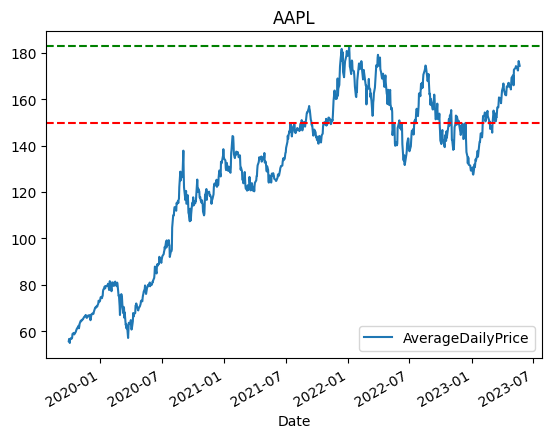

Using Caculated WACC as 0.114757400201081


In [25]:

start_date = df_cash_flow_statement.loc['operatingCashFlow'].index[3]

data = yf.download(ticker, start_date) 
#use yahoo finance to get the historical stock price data

data['AverageDailyPrice']=(data['Open']+data['High'])/2 #create a column for average daily price
#data['AverageDailyPrice']

ax =data.plot(y='AverageDailyPrice') #plot the average daily price
plt.title(f"{ticker}")
plt.xlabel(data.index.name)

ax.axhline(y=Final_Price_Between[1], color='red', linestyle='--') #plot the projected lowest price
ax.axhline(y=Final_Price_Between[0], color='green', linestyle='--') #plot the projected highest price

# vline_timestamp = time_of_current
# ax.axvline(x=vline_timestamp, color='blue', linestyle='-.')

plt.show()
print("Using Caculated WACC as "+f"{Required_Return}")

In [ ]:
sg.theme('DarkAmber')   # Add a touch of color

sg.set_options(text_justification = 'right')

layout = [  [sg.Text('DCF Model Simulation', font='_ 14', justification='c', expand_x=True)],
            [sg.Text('Enter the stock\'s ticker', size = (30,1)), sg.InputText(key = 'ticker')],
            [sg.Text('Enter the limit', size = (30,1)), sg.InputText(key = 'limit')],
            [sg.Text('How many years of data to look at', size = (30,1)), sg.InputCombo((1,2,3,4,5), size = (5, 1), key = 'pastyear')],
            [sg.Text('Enter the current year', size = (30,1)), sg.InputText(key = 'nowyear')],
            [sg.Text('Choose the period', size = (30,1)), sg.InputCombo(('Annual', 'TTM'), size = (10, 1), key = 'period')],
            [sg.Text('Enter your API Key', size = (30,1)), sg.InputText(key = 'key')],
            [sg.Text('_' * 100, size = (100,1))],
            [sg.Text('Visualizing statements', font=('Courier New', 15), justification='left')],
            [sg.Radio('Income Statement', "RADIO1", default=True, size = (15,1), key = 'Income_Statement'), 
             sg.Radio('Balance Sheet', "RADIO1", size = (15,1), key = 'Balance_Sheet'), 
             sg.Radio('Cash Flow Statement', "RADIO1", size = (15,1), key = 'Cash_Flow_Statement')],
            [sg.Radio('key metrics', "RADIO1", size = (15,1), key = 'key_metrics'), 
             sg.Radio('enterprise value', "RADIO1", size = (15,1), key = 'enterprise_value'), 
             sg.Radio('financial ratios', "RADIO1", size = (15,1), key = 'financial_ratios')],
            [sg.Text('Enter the risk free rate', size = (30,1)), sg.InputText(key = 'riskfree')],
            [sg.Button('Submit'), sg.Button('Cancel')]
            ]

window = sg.Window('DCF Model', layout)
# output an error message at the end of the window if crucial values are missing
# Is there a way to click submit and jump to the next page, where it shows all the tables/charts?
while True:
    # Read in any events and the current state of the window
    event, values = window.read()
    # If we eclosed the window or clicked the Cancel button, break out of the
    # loop
    if event == sg.WIN_CLOSED or event == 'Cancel': # if user closes window or clicks cancel
        break
    ticker = str(values['ticker'])
    limit = int(values['limit'])
    pastyear = int(values['pastyear'])
    nowyear = int(values['nowyear'])
    period = str(values['period'])
    key = str(values['key'])

    if event == 'Submit' and values['Income_Statement'] == True:
        display(get_income_statement(ticker, limit, key, period))
    elif event == 'Submit' and values['Balance_Sheet'] == True:
        display(get_balance_sheet(ticker, limit, key, period))
    elif event == 'Submit' and values['Cash_Flow_Statement'] == True:
        display(get_cash_flow_statement(ticker, limit, key, period))
    elif event == 'Submit' and values['key_metrics'] == True:
        display(get_key_metrics(ticker, limit, key, period))
    elif event == 'Submit' and values['enterprise_value'] == True:
        display(get_enterprise_value(ticker, rate=10, key=key, period=period))
    elif event == 'Submit' and values['financial_ratios'] == True:
        display(get_financial_ratios(ticker, limit, key, period))

window.close()


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=2ec7deb9-abbc-4b73-ad7f-dbdabce8c881' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>